# IMDB Movie Review Sentiment Analysis

## Data Preprocessing

#### Table of Contents

- [Library Imports](#Library-Imports)
- [Data Reading](#Data-Reading)
- [Data Cleaning](#Data-Cleaning)
- [Text Preprocessing](#Text-Preprocessing)
- [Topic Modeling](#Topic-Modeling)

#### Library Imports

In [2]:
import re
import string
import spacy
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import scattertext as st
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from spellchecker import SpellChecker
from corextopic import vis_topic as vt
from corextopic import corextopic as ct
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

#### Data Reading

In [3]:
mov_reviews = pd.read_csv('movie_reviews.csv', index_col=0)

In [3]:
mov_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253039 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review     253039 non-null  object
 1   sentiment  253039 non-null  object
dtypes: object(2)
memory usage: 5.8+ MB


Data doesn't contain any null values

In [4]:
mov_reviews.head(5)

,review,sentiment
0,Hakuna Matata. What a wonderful phrase. Hakuna...,positive
1,Obviously a second attempt at the Hugh Glass s...,positive
2,"If some studio head, or person who was ivolved...",negative
3,Rocknrolla rocked me big time. I fall for ever...,positive
4,"Finally, harry potter has a better movie than ...",positive


In [5]:
mov_reviews.sample(5)

,review,sentiment
72060,Good movie with almost a new Idea ...\nNot too...,positive
8982,"Remaking a classic is no joke, but people try ...",negative
96925,"Pre-9/11 and the 'war on terror', you'd be for...",positive
46590,Do you hear that sound? That's the sound of H....,negative
130529,Ever had a lump stuck in your throat for 2 hou...,positive


In [6]:
mov_reviews.tail(5)

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


#### Data Cleaning

Drop duplicates (if present)

In [7]:
mov_reviews.drop_duplicates(inplace=True)

#### Sentiment Balance

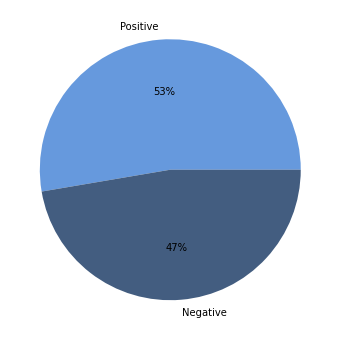

In [41]:
# colors=sns.dark_palette("#69d", n_colors=10)[7:10], 
plt.figure(figsize=[6, 6])
sentiment_vals = list(mov_reviews['sentiment'].value_counts())
labels = ['Positive', 'Negative']
colors = ['#6699DD', '#435D80']
plt.pie(sentiment_vals, labels=labels, colors=colors, autopct='%.0f%%');
plt.savefig('Images/sentiment_balance.png', transparent=True, bbox_inches='tight')

#### Text Preprocessing

In [4]:
mov_reviews = mov_reviews[mov_reviews['review'].map(lambda x: x.isascii())]

In [5]:
# replace apostrophe with blank
replace_apostrophe = lambda x: x.replace("'", '')

# take only alphanumeric
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# to lower case
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# remove repeated characters in words
repeated_chars = lambda x: re.sub('(.)\\1{2,}', '\\1', x)

In [6]:
mov_reviews['review'] = mov_reviews.review.map(replace_apostrophe).map(alphanumeric).map(punc_lower).map(repeated_chars)

Spell checking

In [12]:
spell = SpellChecker()

def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [13]:
mov_reviews["review"] = mov_reviews["review"].apply(lambda text: correct_spellings(text))

Save copy of spell checked DataFrame

In [8]:
mov_reviews.to_pickle('movie_reviews_spell_checked.pkl')

In [9]:
mov_reviews = pd.read_pickle('movie_reviews_spell_checked.pkl')

spaCy pipeline (Tokenization, stop word removal, lemmatization...etc)

In [10]:
nlp = spacy.load('en_core_web_sm', exclude=['parser'])

In [ ]:
mov_reviews['spacy_doc'] = list(nlp.pipe(mov_reviews['review']))

In [ ]:
non_stopwords = []
for doc in mov_reviews.spacy_doc:
    non_stopwords.append([token for token in doc if not token.is_stop])
    
mov_reviews['spacy_doc_no_stopwords'] = non_stopwords

In [ ]:
non_entities = []
for doc in mov_reviews.spacy_doc_no_stopwords:
    non_entities.append([token for token in doc if token.ent_iob_ == 'O'])
    
mov_reviews['spacy_doc_no_stopwords_entities'] = non_entities

In [ ]:
lemmas = []
for doc in mov_reviews.spacy_doc_no_stopwords:
    lemmas.append([token.lemma_ for token in doc])
    
mov_reviews['spacy_doc_no_stopwords_lemma'] = lemmas

In [ ]:
mov_reviews['clean_review'] = mov_reviews['spacy_doc_no_stopwords_lemma'].apply(lambda x: ' '.join(x))

In [ ]:
mov_reviews

Save DataFrame to pickle

In [ ]:
mov_reviews[['review', 'clean_review', 'sentiment']].to_pickle('Data/movie_reviews_cleaned_spacy.pkl')

In [42]:
mov_reviews = pd.read_pickle('Data/movie_reviews_cleaned_spacy.pkl')

#### Word Cloud

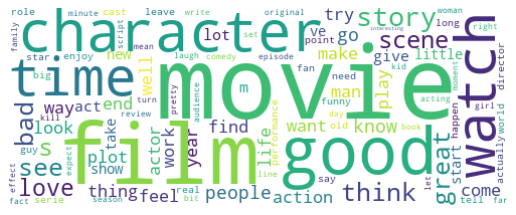

In [43]:
text = " ".join(mov_reviews["clean_review"])

wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white",
                      width=500, height=200, collocations=False
                     ).generate(text)

plt.figure(figsize=[9, 4])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
# plt.title("Most Repeated Words in Reviews", c='w')
plt.savefig('Images/repeated_words_wordcloud.png', bbox_inches='tight', transparent=True)

#### Topic Modeling

CorEx

In [53]:
stop_words = ['go', 'not', 'take', 'give', 'get', 'come', 'like', 'know', 'look', 'make', 'try', 'see', 'say', 'good',
              'big', 've', 'day', 'want', 'movie', 'film','use', 'actually', 'include', 'begin', 'let', 'need', 'have',
              'interesting', 'read', 'bit', 'well', 'base', 'think', 'bring', 'sure', 'lot', 'tell', 'help', 'ask',
              'mention', 'james', 'john', 'oh', 'attempt', 'find', 'place', 'thing', 'guy', 'main', 'right', 'probably',
              'suppose', 'instead', 'especially', 'work', 'mean', 'meet', 'add', 'follow', 'element', 'review', 'fact',
              'face']

anchors = [['act', 'acting', 'actor', 'actress']]

vectorizer = CountVectorizer(max_features=1500, stop_words=stop_words, binary=True)
doc_word = vectorizer.fit_transform(mov_reviews['clean_review'])
words = list(np.asarray(vectorizer.get_feature_names_out()))

topic_model = ct.Corex(n_hidden=7, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=mov_reviews['clean_review'], anchors=anchors, anchor_strength=2)

topics = topic_model.get_topics()
for n, topic in enumerate(topics):
    topic_words, _, _ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: actor, play, director, act, set, audience, lead, screen, moment, human
1: character, scene, time, action, plot, feel, point, effect, long, sequence
2: war, fight, star, hero, course, power, battle, return, lose, evil
3: bad, kill, turn, run, money, head, away, die, dead, save
4: life, man, young, year, live, world, old, father, woman, family
5: performance, story, role, great, cast, music, beautiful, love, perfect, cinematography
6: way, end, people, start, little, happen, leave, minute, reason, pretty


LSA

In [67]:
def embed(transformer, corpus):
    return transformer.fit_transform(corpus)
def LSA(transformer, corpus):
    lsa = TruncatedSVD(7)
    doc_topic = lsa.fit_transform(embed(transformer, corpus))
    print('Variance Ratio:')
    print(lsa.explained_variance_ratio_,'\n')
    print('Sum of Variance Ratio:',lsa.explained_variance_ratio_.sum(),'\n')
    display_topics(lsa, transformer.get_feature_names(), 10)
    column_names = []
    for i in range(0,9):
        column_names.append('Topic_' + str(i))
        
LSA(vectorizer,mov_reviews['clean_review'])

Variance Ratio:
[0.02944214 0.00835914 0.00774171 0.00657425 0.00578448 0.00560763
 0.00537999] 

Sum of Variance Ratio: 0.06888934715133227 


Topic  0
time, character, watch, story, great, way, scene, bad, people, end

Topic  1
play, performance, life, man, role, world, director, young, set, lead

Topic  2
bad, people, plot, kill, minute, end, waste, money, point, happen

Topic  3
watch, life, love, people, year, show, live, family, world, old

Topic  4
time, great, actor, play, performance, role, cast, year, funny, comedy

Topic  5
character, funny, great, comedy, love, laugh, bad, episode, play, joke

Topic  6
watch, bad, actor, act, great, story, people, scene, director, acting


NMF

In [66]:
nmf_model = NMF(7)
doc_topic = nmf_model.fit_transform(doc_word)

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(nmf_model, vectorizer.get_feature_names(), 10)

c:\users\abdal\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(



Topic  0
life, way, man, year, people, world, end, real, old, leave

Topic  1
watch, love, people, enjoy, episode, show, feel, season, funny, start

Topic  2
character, plot, series, feel, episode, development, way, season, show, care

Topic  3
bad, plot, scene, act, acting, minute, people, end, script, actor

Topic  4
great, actor, cast, performance, role, scene, play, action, love, act

Topic  5
story, line, love, end, true, acting, feel, beautiful, act, effect

Topic  6
time, waste, long, money, spend, laugh, hour, year, feel, screen


c:\users\abdal\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\users\abdal\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Remove common words used in both positive and negative reviews

In [3]:
pos_reviews = mov_reviews[mov_reviews['sentiment'] == 'positive']
neg_reviews = mov_reviews[mov_reviews['sentiment'] == 'negative']

In [30]:
all_pos_words = []
all_neg_words = []

for review in pos_reviews.clean_review:
    for word in review.split():
        all_pos_words.append(word)
        
for review in neg_reviews.clean_review:
    for word in review.split():
        all_neg_words.append(word)
        
pos_words_count = Counter(all_pos_words)
neg_words_count = Counter(all_neg_words)
        
to_be_removed = []
for word in list(pos_words_count.keys()):
    if word in all_neg_words:
        to_be_removed.append(word)
        
for word in to_be_removed:
    pos_words_count.pop(word, None)
    neg_words_count.pop(word, None)
    
top_10_pos = dict(pos_words_count.most_common(10))
top_10_neg = dict(neg_words_count.most_common(10))

Plot top 10 most common words in positive and negative reviews

In [31]:
top_10_pos.keys()

dict_keys(['apretty', 'kore', 'matsuko', 'prot', 'langda', 'efraim', 'vikramaditya', 'konna', 'prue', 'gunga'])

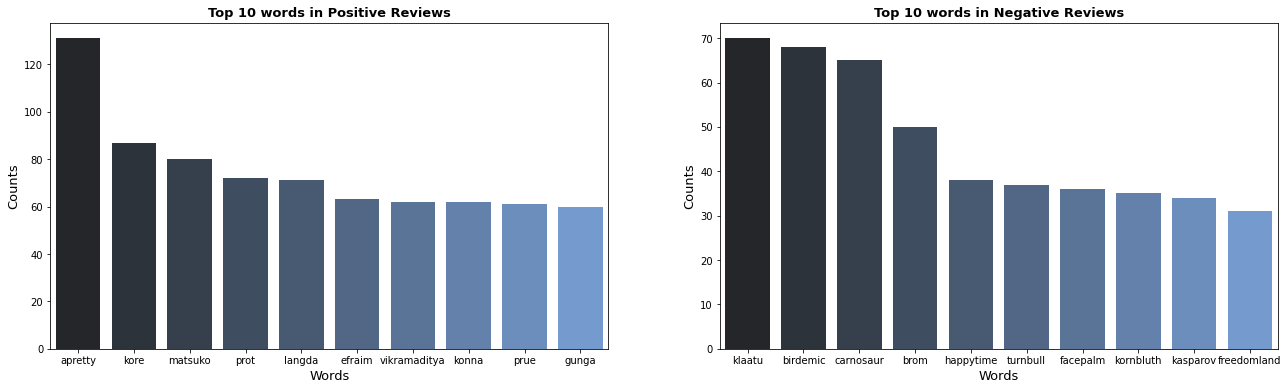

In [32]:
palette = sns.dark_palette("#69d", n_colors=10)

fig, ax = plt.subplots(1, 2, figsize=[22, 6])
plt.xlabel('Words', fontsize=13)
plt.ylabel('Counts', fontsize=13)
sns.barplot(x=list(top_10_pos.keys()), y=list(top_10_pos.values()), palette=palette, ax=ax[0]).set_title('Top 10 words in Positive Reviews', fontweight='bold', fontsize=13);
sns.barplot(x=list(top_10_neg.keys()), y=list(top_10_neg.values()), palette=palette, ax=ax[1]).set_title('Top 10 words in Negative Reviews', fontweight='bold', fontsize=13);
ax[0].set_xlabel('Words', fontsize=13)
ax[0].set_ylabel('Counts', fontsize=13);
plt.savefig('Images/top_10_pos_neg_words.png', bbox_inches='tight', transparent=True)

Build Scattertext HTML file of each word in the reviews ranging from positive to negative

In [ ]:
corpus = st.CorpusFromPandas(mov_reviews,
                             category_col='sentiment',
                             text_col='clean_review',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build()

In [ ]:
html = st.produce_scattertext_explorer(
        corpus,
        category='positive',
        category_name='Positive Review',
        not_category_name='Negative Review',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        )

In [ ]:
open('Data/demo.html', 'wb').write(html.encode('utf-8'));